# Task 2: Multi Product with B constrain


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize

# Environment Setup

In this notebook, we implement a Combinatorial UCB algorithm for multi-product pricing with inventory constraints. 

The scenario involves:
- Multiple products with different customer valuation distributions
- Limited inventory for each product
- Combinatorial action space where we select a subset of products to offer
- Goal: Maximize revenue while respecting inventory constraints

In [2]:
class MultiProductPricingEnvironment:
    """
    Multi-product stochastic environment for dynamic pricing with inventory constraints.
    
    This environment simulates a multi-product pricing scenario where:
    - Each product has its own customer valuation distribution
    - Customers have different preferences for different products
    - Each round represents one customer interaction
    - The customer can purchase multiple products or none at all
    """
    def __init__(self, valuation_distributions, correlation_matrix=None):
        """
        Initialize the multi-product pricing environment.
        
        Args:
            valuation_distributions: List of scipy.stats distributions for each product
            correlation_matrix: Optional correlation matrix for product valuations
        """
        self.valuation_dists = valuation_distributions
        self.n_products = len(valuation_distributions)
        self.correlation_matrix = correlation_matrix
        
        # If no correlation matrix provided, assume independence
        if correlation_matrix is None:
            self.correlation_matrix = np.eye(self.n_products)
    
    def demand_probability(self, prices, product_subset):
        """
        Calculate the theoretical probability that a customer purchases 
        the given subset of products at given prices.
        
        Args:
            prices: Array of prices for each product
            product_subset: List of product indices being offered
            
        Returns:
            Probability that customer will purchase this product subset
        """
        if len(product_subset) == 0:
            return 0.0
        
        # For simplicity, assume independent purchase decisions
        # In practice, this could be more complex with substitution effects
        prob = 1.0
        for product_idx in product_subset:
            # Probability that customer values this product >= its price
            product_prob = 1 - self.valuation_dists[product_idx].cdf(prices[product_idx])
            prob *= product_prob
        
        return prob
    
    def simulate_round(self, prices, product_subset):
        """
        Simulate one customer interaction for a given product subset and prices.
        
        Args:
            prices: Array of prices for each product
            product_subset: List of product indices being offered
            
        Returns:
            tuple: (products_purchased, total_revenue) where:
                - products_purchased: List of products actually purchased
                - total_revenue: Sum of revenues from purchased products
        """
        if len(product_subset) == 0:
            return [], 0.0
        
        products_purchased = []
        total_revenue = 0.0
        
        # Generate customer valuations for all products
        valuations = np.array([dist.rvs() for dist in self.valuation_dists])
        
        # Customer purchases products where valuation >= price
        for product_idx in product_subset:
            if valuations[product_idx] >= prices[product_idx]:
                products_purchased.append(product_idx)
                total_revenue += prices[product_idx]
        
        return products_purchased, total_revenue

# Combinatorial UCB Agent with LP-based Inventory Constraints

In [ ]:
class CombinatorialUCBWithInventory:
    """
    Combinatorial UCB agent for multi-product pricing with inventory constraints.
    
    This agent implements a combinatorial bandit approach where:
    1. Actions are product-price combinations for each product
    2. Each product has limited inventory
    3. UCB confidence bounds guide exploration vs exploitation
    4. Linear programming optimizes the product-price selection considering inventory constraints
    5. Uses LP-based action selection similar to single-product UCB but extended to multiple products
    """
    
    def __init__(self, n_products, price_options, inventory_per_product, T, 
                 confidence_bound=1.0, rho_penalty=1.0, use_pen_rho=True):
        """
        Initialize the combinatorial UCB agent with LP-based action selection.
        
        Args:
            n_products: Number of products
            price_options: List of possible prices for each product
            inventory_per_product: Initial inventory for each product
            T: Time horizon (number of rounds)
            confidence_bound: UCB confidence parameter
            rho_penalty: Penalty factor for inventory constraint (>1 = more conservative)
            use_pen_rho: Whether to use penalty factor for inventory constraints
        """
        self.n_products = n_products
        self.price_options = np.array(price_options)
        self.T = T
        self.confidence_bound = confidence_bound
        self.rho_penalty = rho_penalty
        self.use_pen_rho = use_pen_rho
        
        # Inventory management
        self.initial_inventory = np.array(inventory_per_product, dtype=float)
        self.remaining_inventory = np.array(inventory_per_product, dtype=float)
        
        # Target selling rates for each product
        self.rho = self.initial_inventory / T  # Target selling rate per product
        
        # Statistics for each (product, price) combination
        self.n_price_options = len(price_options)
        self.avg_revenue = np.zeros((n_products, self.n_price_options))
        self.avg_purchase_prob = np.zeros((n_products, self.n_price_options))
        self.n_pulls = np.zeros((n_products, self.n_price_options))
        
        # Current state
        self.t = 0
        self.current_action_indices = None  # price indices for each product
        
        # History tracking
        self.history = {
            'actions': [],
            'revenues': [],
            'purchases': [],
            'inventory_levels': [],
            'price_distributions': []  # Store computed price distributions
        }
    
    def select_action(self):
        """
        Select actions for each product using LP-based UCB with inventory constraints.
        
        For each product with remaining inventory:
        1. Compute UCB bounds on revenue and LCB bounds on purchase probability
        2. Solve LP to get optimal price distribution for that product
        3. Sample price according to the distribution
        
        Returns:
            tuple: (product_subset, prices) where:
                - product_subset: List of product indices with inventory
                - prices: List of selected prices for each product
        """
        product_subset = []
        prices = []
        action_map = {}  # Maps product_idx to price_idx
        
        # Process each product independently
        for product_idx in range(self.n_products):
            if self.remaining_inventory[product_idx] < 1:
                continue  # Skip products with no inventory
            
            # Select price for this product using LP
            price_idx = self._select_price_for_product(product_idx)
            
            if price_idx is not None:
                product_subset.append(product_idx)
                prices.append(self.price_options[price_idx])
                action_map[product_idx] = price_idx
        
        # Store current action for update
        self.current_action_map = action_map
        
        return product_subset, prices
    
    def _select_price_for_product(self, product_idx):
        """
        Select price for a single product using LP-based UCB approach.
        
        Args:
            product_idx: Index of the product
            
        Returns:
            Selected price index, or None if no valid price
        """
        # Exploration phase: try each price at least once
        if self.t < self.n_price_options * self.n_products:
            # Round-robin exploration across all product-price combinations
            exploration_idx = self.t % (self.n_price_options * self.n_products)
            target_product = exploration_idx // self.n_price_options
            target_price = exploration_idx % self.n_price_options
            
            if target_product == product_idx:
                return target_price
            else:
                # If not this product's turn, select based on current knowledge
                if np.sum(self.n_pulls[product_idx, :]) == 0:
                    return 0  # Select first price if never tried
                else:
                    return np.argmax(self.avg_revenue[product_idx, :])
        
        # LP-based exploitation phase
        # Compute UCB bounds on revenue
        confidence_radius = self.confidence_bound * np.sqrt(
            2 * np.log(max(1, self.t)) / np.maximum(self.n_pulls[product_idx, :], 1)
        )
        f_ucbs = self.avg_revenue[product_idx, :] + confidence_radius
        
        # Compute LCB bounds on purchase probability
        demand_confidence_radius = self.confidence_bound * np.sqrt(
            2 * np.log(max(1, self.t)) / np.maximum(self.n_pulls[product_idx, :], 1)
        )
        c_lcbs = np.maximum(0, self.avg_purchase_prob[product_idx, :] - demand_confidence_radius)
        
        # Solve LP to get optimal price distribution for this product
        gamma_t = self._compute_optimal_distribution(product_idx, f_ucbs, c_lcbs)
        
        # Sample price according to computed distribution
        price_idx = np.random.choice(self.n_price_options, p=gamma_t)
        
        return price_idx
    
    def _compute_optimal_distribution(self, product_idx, f_ucbs, c_lcbs):
        """
        Solve LP to find optimal price distribution for a single product with inventory constraints.
        
        Formulation for product k:
        maximize: sum_i gamma_i * f_ucb_i (expected revenue for product k)
        subject to: sum_i gamma_i * c_lcb_i <= current_rho_k (inventory constraint for product k)
                   sum_i gamma_i = 1 (probability constraint)
                   gamma_i >= 0 (non-negativity)
        
        Args:
            product_idx: Index of the product
            f_ucbs: Upper confidence bounds on revenue for each price
            c_lcbs: Lower confidence bounds on purchase probability for each price
            
        Returns:
            gamma: Probability distribution over prices for this product
        """
        # Handle edge case: if no positive demand expected, choose highest revenue price
        if np.all(c_lcbs <= 1e-10):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1.0
            return gamma
        
        # Convert to minimization problem (negate revenues)
        c = -f_ucbs
        
        # Compute current required selling rate for this product
        remaining_rounds = max(1, self.T - self.t)
        current_rho = max(self.remaining_inventory[product_idx] / remaining_rounds, 0)
        
        # Linear program constraints
        A_ub = [c_lcbs]  # Inventory constraint coefficients
        
        if self.use_pen_rho:
            # Apply penalty to make constraint more conservative
            inventory_ratio = self.remaining_inventory[product_idx] / self.initial_inventory[product_idx]
            time_ratio = (self.T - self.t) / self.T
            
            if inventory_ratio > 0.5 and time_ratio > 0.5:
                # Early stages with plenty of inventory: relax constraint
                penalty_factor = self.rho_penalty * 1.5
            elif inventory_ratio < 0.1:
                # Low inventory: tighten constraint
                penalty_factor = self.rho_penalty * 0.5
            else:
                penalty_factor = self.rho_penalty
            
            penalized_rho = current_rho * penalty_factor
            
            # If the constraint is too tight, relax it
            min_demand = np.min(c_lcbs[c_lcbs > 0]) if np.any(c_lcbs > 0) else 0
            if penalized_rho < min_demand * 0.5:
                penalized_rho = min_demand * 0.8
            
            b_ub = [penalized_rho]
        else:
            b_ub = [current_rho]
        
        A_eq = [np.ones(self.n_price_options)]  # Probability constraint coefficients
        b_eq = [1]  # Probability constraint bound
        
        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                                 bounds=[(0, 1) for _ in range(self.n_price_options)], method='highs')
            if res.success:
                gamma = res.x
                # Ensure valid probability distribution
                gamma = np.maximum(gamma, 0)
                gamma = gamma / np.sum(gamma) if np.sum(gamma) > 0 else np.ones(self.n_price_options) / self.n_price_options
                return gamma
            else:
                # Fallback: uniform distribution
                return np.ones(self.n_price_options) / self.n_price_options
        except:
            # Fallback: uniform distribution
            return np.ones(self.n_price_options) / self.n_price_options
    
    def update(self, products_purchased, total_revenue):
        """
        Update agent statistics based on observed outcome.
        
        Args:
            products_purchased: List of products actually purchased
            total_revenue: Total revenue obtained
        """
        if not hasattr(self, 'current_action_map') or not self.current_action_map:
            return
        
        # Update statistics for each product that was offered
        for product_idx, price_idx in self.current_action_map.items():
            # Update pull count
            self.n_pulls[product_idx, price_idx] += 1
            
            # Determine if this specific product was purchased
            was_purchased = product_idx in products_purchased
            price = self.price_options[price_idx]
            revenue_from_product = price if was_purchased else 0.0
            
            # Update average revenue using incremental mean
            self.avg_revenue[product_idx, price_idx] += (
                revenue_from_product - self.avg_revenue[product_idx, price_idx]
            ) / self.n_pulls[product_idx, price_idx]
            
            # Update average purchase probability
            purchase_indicator = 1.0 if was_purchased else 0.0
            self.avg_purchase_prob[product_idx, price_idx] += (
                purchase_indicator - self.avg_purchase_prob[product_idx, price_idx]
            ) / self.n_pulls[product_idx, price_idx]
            
            # Update inventory if product was purchased
            if was_purchased and self.remaining_inventory[product_idx] > 0:
                self.remaining_inventory[product_idx] -= 1
        
        # Record history 
        product_subset = list(self.current_action_map.keys())
        price_indices = list(self.current_action_map.values())
        
        self.history['actions'].append((product_subset.copy(), price_indices.copy()))
        self.history['revenues'].append(total_revenue)
        self.history['purchases'].append(products_purchased.copy())
        self.history['inventory_levels'].append(self.remaining_inventory.copy())
        
        # Increment time
        self.t += 1
    
    def get_best_strategy(self):
        """
        Return the best strategy learned so far for each product.
        
        Returns:
            Dictionary with best price and performance for each product
        """
        best_strategies = {}
        
        for product_idx in range(self.n_products):
            best_price_idx = np.argmax(self.avg_revenue[product_idx, :])
            best_price = self.price_options[best_price_idx]
            best_revenue = self.avg_revenue[product_idx, best_price_idx]
            best_prob = self.avg_purchase_prob[product_idx, best_price_idx]
            
            best_strategies[product_idx] = {
                'best_price': best_price,
                'avg_revenue': best_revenue,
                'purchase_prob': best_prob,
                'pulls': self.n_pulls[product_idx, best_price_idx]
            }
        
        return best_strategies

# Theoretical Optimal Solution

In [4]:
def compute_optimal_policy(environment, price_options, inventory_per_product, T):
    """
    Compute the optimal policy for multi-product pricing with inventory constraints.
    
    This solves a complex combinatorial optimization problem to find the optimal
    strategy for offering product subsets and prices over time.
    
    Args:
        environment: MultiProductPricingEnvironment instance
        price_options: List of available prices
        inventory_per_product: Inventory limits for each product
        T: Time horizon
        
    Returns:
        Dictionary containing optimal policy information
    """
    n_products = environment.n_products
    
    # For simplification, we'll compute the optimal single-product policies
    # and use them as a baseline (this is suboptimal for the true combinatorial problem)
    
    optimal_policies = {}
    total_expected_revenue = 0.0
    
    for product_idx in range(n_products):
        best_price = None
        best_expected_revenue = 0.0
        best_purchase_prob = 0.0
        
        # Find best price for this product individually
        for price in price_options:
            # Create a single-product scenario
            purchase_prob = 1 - environment.valuation_dists[product_idx].cdf(price)
            expected_revenue_per_round = price * purchase_prob
            
            if expected_revenue_per_round > best_expected_revenue:
                best_expected_revenue = expected_revenue_per_round
                best_price = price
                best_purchase_prob = purchase_prob
        
        optimal_policies[product_idx] = {
            'optimal_price': best_price,
            'expected_revenue_per_round': best_expected_revenue,
            'purchase_probability': best_purchase_prob,
            'expected_total_revenue': best_expected_revenue * min(T, inventory_per_product[product_idx] / best_purchase_prob)
        }
        
        # Add to total (this is an upper bound since we ignore combinatorial constraints)
        total_expected_revenue += optimal_policies[product_idx]['expected_total_revenue']
    
    return {
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': total_expected_revenue
    }


def generate_all_product_combinations(n_products):
    """
    Generate all possible product subset combinations.
    
    Args:
        n_products: Total number of products
        
    Returns:
        List of product subset tuples
    """
    from itertools import combinations
    
    all_combinations = []
    for subset_size in range(1, n_products + 1):
        for combination in combinations(range(n_products), subset_size):
            all_combinations.append(combination)
    
    return all_combinations

# Simulation and Evaluation

In [5]:
def run_combinatorial_simulation(environment, agent, T, verbose=True):
    """
    Run a complete simulation of the combinatorial UCB algorithm.
    
    Args:
        environment: MultiProductPricingEnvironment instance
        agent: CombinatorialUCBWithInventory instance
        T: Number of rounds to simulate
        verbose: Whether to print progress information
        
    Returns:
        Dictionary containing simulation results
    """
    total_revenue = 0.0
    total_products_sold = 0
    revenue_per_round = []
    cumulative_revenue = []
    
    if verbose:
        print(f"=== Running Combinatorial UCB Simulation for {T} rounds ===")
        print(f"Products: {environment.n_products}")
        print(f"Initial inventory: {agent.initial_inventory}")
        print(f"Price options: {agent.price_options}")
    
    for t in range(T):
        # Agent selects product subset and prices
        product_subset, prices = agent.select_action()
        
        if not product_subset:
            # No products available (inventory exhausted)
            revenue = 0.0
            products_purchased = []
        else:
            # Convert to price array for environment
            price_array = np.zeros(environment.n_products)
            for i, product_idx in enumerate(product_subset):
                price_array[product_idx] = prices[i]
            
            # Simulate customer interaction
            products_purchased, revenue = environment.simulate_round(price_array, product_subset)
        
        # Update agent with outcome
        agent.update(products_purchased, revenue)
        
        # Track statistics
        total_revenue += revenue
        total_products_sold += len(products_purchased)
        revenue_per_round.append(revenue)
        cumulative_revenue.append(total_revenue)
        
        # Print progress occasionally
        if verbose and (t + 1) % (T // 10) == 0:
            remaining_inventory = np.sum(agent.remaining_inventory)
            print(f"Round {t + 1:4d}: Revenue = {revenue:6.2f}, "
                  f"Cumulative = {total_revenue:8.2f}, "
                  f"Products sold this round = {len(products_purchased)}, "
                  f"Remaining inventory = {remaining_inventory:.0f}")
    
    if verbose:
        print(f"\n=== Simulation Complete ===")
        print(f"Total revenue: {total_revenue:.2f}")
        print(f"Average revenue per round: {total_revenue / T:.2f}")
        print(f"Total products sold: {total_products_sold}")
        print(f"Remaining inventory: {agent.remaining_inventory}")
        print(f"Inventory utilization: {100 * (1 - np.sum(agent.remaining_inventory) / np.sum(agent.initial_inventory)):.1f}%")
    
    return {
        'total_revenue': total_revenue,
        'revenue_per_round': revenue_per_round,
        'cumulative_revenue': cumulative_revenue,
        'total_products_sold': total_products_sold,
        'final_inventory': agent.remaining_inventory.copy(),
        'inventory_utilization': 1 - np.sum(agent.remaining_inventory) / np.sum(agent.initial_inventory),
        'agent': agent
    }

# Visualization and Analysis

In [10]:
def plot_combinatorial_results(results, optimal_policy, T, environment):
    """
    Generate comprehensive visualizations for combinatorial UCB results.
    
    Args:
        results: Simulation results dictionary
        optimal_policy: Theoretical optimal policy
        T: Number of rounds
        environment: Environment instance
    """
    agent = results['agent']
    revenue_per_round = results['revenue_per_round']
    cumulative_revenue = results['cumulative_revenue']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Cumulative Revenue vs Theoretical Upper Bound
    optimal_upper_bound = optimal_policy['total_expected_revenue_upper_bound']
    
    axes[0, 0].plot(cumulative_revenue, label='Combinatorial UCB', linewidth=3, color='blue', alpha=0.8)
    axes[0, 0].plot([optimal_upper_bound * (t+1) / T for t in range(T)], 
                    label='Theoretical Upper Bound', linestyle='--', linewidth=3, color='red', alpha=0.8)
    
    # Performance percentage
    final_performance = (results['total_revenue'] / optimal_upper_bound) * 100
    axes[0, 0].text(0.02, 0.98, f'Performance: {final_performance:.1f}%\nof Upper Bound', 
                    transform=axes[0, 0].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.7))
    
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Cumulative Revenue')
    axes[0, 0].set_title('Revenue Performance: Combinatorial UCB vs Upper Bound')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Revenue per Round (with moving average)
    window_size = min(100, T // 20)
    if window_size > 1:
        moving_avg = np.convolve(revenue_per_round, np.ones(window_size)/window_size, mode='valid')
        axes[0, 1].plot(range(window_size-1, T), moving_avg, linewidth=3, 
                       label=f'Revenue (MA-{window_size})', color='blue', alpha=0.8)
    else:
        axes[0, 1].plot(revenue_per_round, linewidth=1, alpha=0.7, 
                       label='Revenue per Round', color='blue')
    
    # Add reference line for average optimal revenue per round
    avg_optimal_per_round = optimal_upper_bound / T
    axes[0, 1].axhline(avg_optimal_per_round, color='red', linestyle='--', linewidth=2,
                       label=f'Avg Optimal ({avg_optimal_per_round:.2f})', alpha=0.8)
    
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Revenue per Round')
    axes[0, 1].set_title('Revenue Convergence Analysis')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Inventory Levels Over Time
    inventory_history = np.array([inv for inv in agent.history['inventory_levels']])
    
    for product_idx in range(environment.n_products):
        axes[0, 2].plot(inventory_history[:, product_idx], 
                       label=f'Product {product_idx}', linewidth=2, alpha=0.8)
    
    axes[0, 2].set_xlabel('Round')
    axes[0, 2].set_ylabel('Remaining Inventory')
    axes[0, 2].set_title('Inventory Depletion Over Time')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Regret Analysis
    # Compute cumulative regret over time
    optimal_revenue_per_round = optimal_upper_bound / T
    cumulative_optimal = np.array([optimal_revenue_per_round * (t+1) for t in range(T)])
    cumulative_regret = cumulative_optimal - np.array(cumulative_revenue)
    
    axes[1, 0].plot(cumulative_regret, linewidth=3, color='red', alpha=0.8, label='Cumulative Regret')
    
    # Add theoretical regret bound
    # For bandits with budget constraints: O(√T log T)
    t_vals = np.arange(1, T + 1)
    theoretical_bound = 2 * np.sqrt(len(agent.price_options) * np.log(t_vals) * t_vals)
    axes[1, 0].plot(t_vals, theoretical_bound, '--', color='blue', alpha=0.7, linewidth=2,
                   label='Theoretical Bound O(√T log T)')
    
    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Cumulative Regret')
    axes[1, 0].set_title('Regret Growth Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Average Regret per Round
    avg_regret = cumulative_regret / t_vals
    
    axes[1, 1].plot(avg_regret, linewidth=3, color='purple', alpha=0.8, label='Average Regret')
    axes[1, 1].axhline(y=0, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Zero Regret')
    
    # Add moving average for smoother visualization
    window = min(500, T // 10)
    if window > 1:
        moving_avg_regret = np.convolve(avg_regret, np.ones(window)/window, mode='valid')
        axes[1, 1].plot(range(window-1, len(avg_regret)), moving_avg_regret, 
                       linewidth=2, alpha=0.8, color='orange', label=f'Moving Avg ({window})')
    
    axes[1, 1].set_xlabel('Round')
    axes[1, 1].set_ylabel('Average Regret per Round')
    axes[1, 1].set_title('Average Regret Convergence')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. R_T/T Analysis
    R_T_over_T = np.array(cumulative_revenue) / (np.arange(1, T + 1))
    axes[1, 2].plot(R_T_over_T, linewidth=3, color='orange', alpha=0.8, label='R_T / T')
    axes[1, 2].axhline(y=optimal_upper_bound / T, color='red', linestyle='--', linewidth=2,
                       label='Optimal Revenue per Round', alpha=0.8)
    axes[1, 2].set_xlabel('Round')
    axes[1, 2].set_ylabel('R_T / T')
    axes[1, 2].set_title('Average Revenue per Round Over Time')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    # Additional Analysis: Best Strategies Summary
    print("\n=== Learned Best Strategies per Product ===")
    best_strategies = agent.get_best_strategy()
    
    for product_idx, strategy in best_strategies.items():
        opt_info = optimal_policy['per_product_policies'][product_idx]
        print(f"Product {product_idx}:")
        print(f"  Learned best price: {strategy['best_price']:.3f} "
              f"(Optimal: {opt_info['optimal_price']:.3f})")
        print(f"  Avg revenue: {strategy['avg_revenue']:.3f} "
              f"(Optimal: {opt_info['expected_revenue_per_round']:.3f})")
        print(f"  Purchase prob: {strategy['purchase_prob']:.3f} "
              f"(Optimal: {opt_info['purchase_probability']:.3f})")
        print(f"  Times tried: {strategy['pulls']:.0f}")
        print()
    
    return {
        'final_performance_pct': final_performance,
        'inventory_utilization': results['inventory_utilization'],
        'best_strategies': best_strategies
    }

# Experimental Setup and Execution

In [7]:
# Experimental Configuration
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Environment parameters
n_products = 3  # Number of different products
T = 10000       # Number of rounds

# Create different valuation distributions for each product
valuation_distributions = [
    stats.norm(loc=0.6, scale=0.1),  # Product 0: Higher value, lower variance
    stats.norm(loc=0.4, scale=0.15), # Product 1: Medium value, medium variance  
    stats.norm(loc=0.5, scale=0.08)  # Product 2: Medium-high value, low variance
]

# Inventory constraints per product
inventory_per_product = [int(T * 0.3), int(T * 0.25), int(T * 0.35)]  # Different inventory levels

# Price options (same for all products for simplicity)
epsilon = min(inventory_per_product)**(-1/3)  # Number of price options based on epsilon
price_options = np.arange(0.1, 0.9, step=epsilon)  # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


print("=== Experimental Setup ===")
print(f"Number of products: {n_products}")
print(f"Time horizon: {T} rounds")
print(f"Price options: {price_options}")
print(f"Initial inventory: {inventory_per_product}")
print(f"Total inventory: {sum(inventory_per_product)}")

# Product valuation info
print("\nProduct valuation distributions:")
for i, dist in enumerate(valuation_distributions):
    print(f"  Product {i}: Normal(μ={dist.mean():.2f}, σ={dist.std():.3f})")

# Create environment
environment = MultiProductPricingEnvironment(valuation_distributions)

# Compute theoretical optimal
print("\n=== Computing Theoretical Optimal ===")
optimal_policy = compute_optimal_policy(
    environment, price_options, inventory_per_product, T
)

print("Optimal single-product policies:")
for product_idx, policy in optimal_policy['per_product_policies'].items():
    print(f"  Product {product_idx}: Price={policy['optimal_price']:.2f}, "
          f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")

=== Experimental Setup ===
Number of products: 3
Time horizon: 10000 rounds
Price options: [0.1        0.17368063 0.24736126 0.32104189 0.39472252 0.46840315
 0.54208378 0.61576441 0.68944504 0.76312567 0.8368063 ]
Initial inventory: [3000, 2500, 3500]
Total inventory: 9000

Product valuation distributions:
  Product 0: Normal(μ=0.60, σ=0.100)
  Product 1: Normal(μ=0.40, σ=0.150)
  Product 2: Normal(μ=0.50, σ=0.080)

=== Computing Theoretical Optimal ===
Optimal single-product policies:
  Product 0: Price=0.47, Revenue/round=0.424
  Product 1: Price=0.32, Revenue/round=0.225
  Product 2: Price=0.39, Revenue/round=0.358

Upper bound total revenue: 3589.34
Upper bound avg revenue/round: 0.359


In [11]:
# Create and run Combinatorial UCB agent
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")

agent = CombinatorialUCBWithInventory(
    n_products=n_products,
    price_options=price_options,
    inventory_per_product=inventory_per_product,
    T=T,
    confidence_bound=1.0,  # UCB confidence parameter
    rho_penalty=1.0,       # Penalty factor for inventory constraint
    use_pen_rho=True       # Use penalty factor for inventory constraints
)


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent.confidence_bound}")
print(f"  Rho penalty factor: {agent.rho_penalty}")
print(f"  Use penalty rho: {agent.use_pen_rho}")
print(f"  Products: {agent.n_products}")
print(f"  Price options per product: {len(agent.price_options)}")
print(f"  Total product-price combinations: {agent.n_products * len(agent.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent, T, verbose=True)


=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1.0
  Rho penalty factor: 1.0
  Use penalty rho: True
  Products: 3
  Price options per product: 11
  Total product-price combinations: 33

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: [3000. 2500. 3500.]
Price options: [0.1        0.17368063 0.24736126 0.32104189 0.39472252 0.46840315
 0.54208378 0.61576441 0.68944504 0.76312567 0.8368063 ]
Round 1000: Revenue =   0.64, Cumulative =   668.40, Products sold this round = 2, Remaining inventory = 7022
Round 1000: Revenue =   0.64, Cumulative =   668.40, Products sold this round = 2, Remaining inventory = 7022
Round 2000: Revenue =   1.55, Cumulative =  1331.56, Products sold this round = 3, Remaining inventory = 5240
Round 2000: Revenue =   1.55, Cumulative =  1331.56, Products sold this round = 3, Remaining inventory = 5240
Round 3000: Revenue =   


=== Analyzing Results ===

=== Learned Best Strategies per Product ===
Product 0:
  Learned best price: 0.468 (Optimal: 0.468)
  Avg revenue: 0.437 (Optimal: 0.424)
  Purchase prob: 0.933 (Optimal: 0.906)
  Times tried: 390

Product 1:
  Learned best price: 0.321 (Optimal: 0.321)
  Avg revenue: 0.224 (Optimal: 0.225)
  Purchase prob: 0.697 (Optimal: 0.701)
  Times tried: 630

Product 2:
  Learned best price: 0.395 (Optimal: 0.395)
  Avg revenue: 0.354 (Optimal: 0.358)
  Purchase prob: 0.898 (Optimal: 0.906)
  Times tried: 781


=== Detailed Performance Analysis ===
Total regret: -290.15
Average regret per round: -0.0290
Regret as % of optimal: -8.08%

Inventory utilization by product:
  Product 0: 3000/3000 = 100.0%
  Product 1: 2500/2500 = 100.0%
  Product 2: 3500/3500 = 100.0%

Exploration statistics:
  Unique actions tried: 1077
  Total product-price combinations: 33
  Average actions per round: 0.92

Revenue statistics:
  Mean revenue per round: 0.388
  Std revenue per round: 0.40

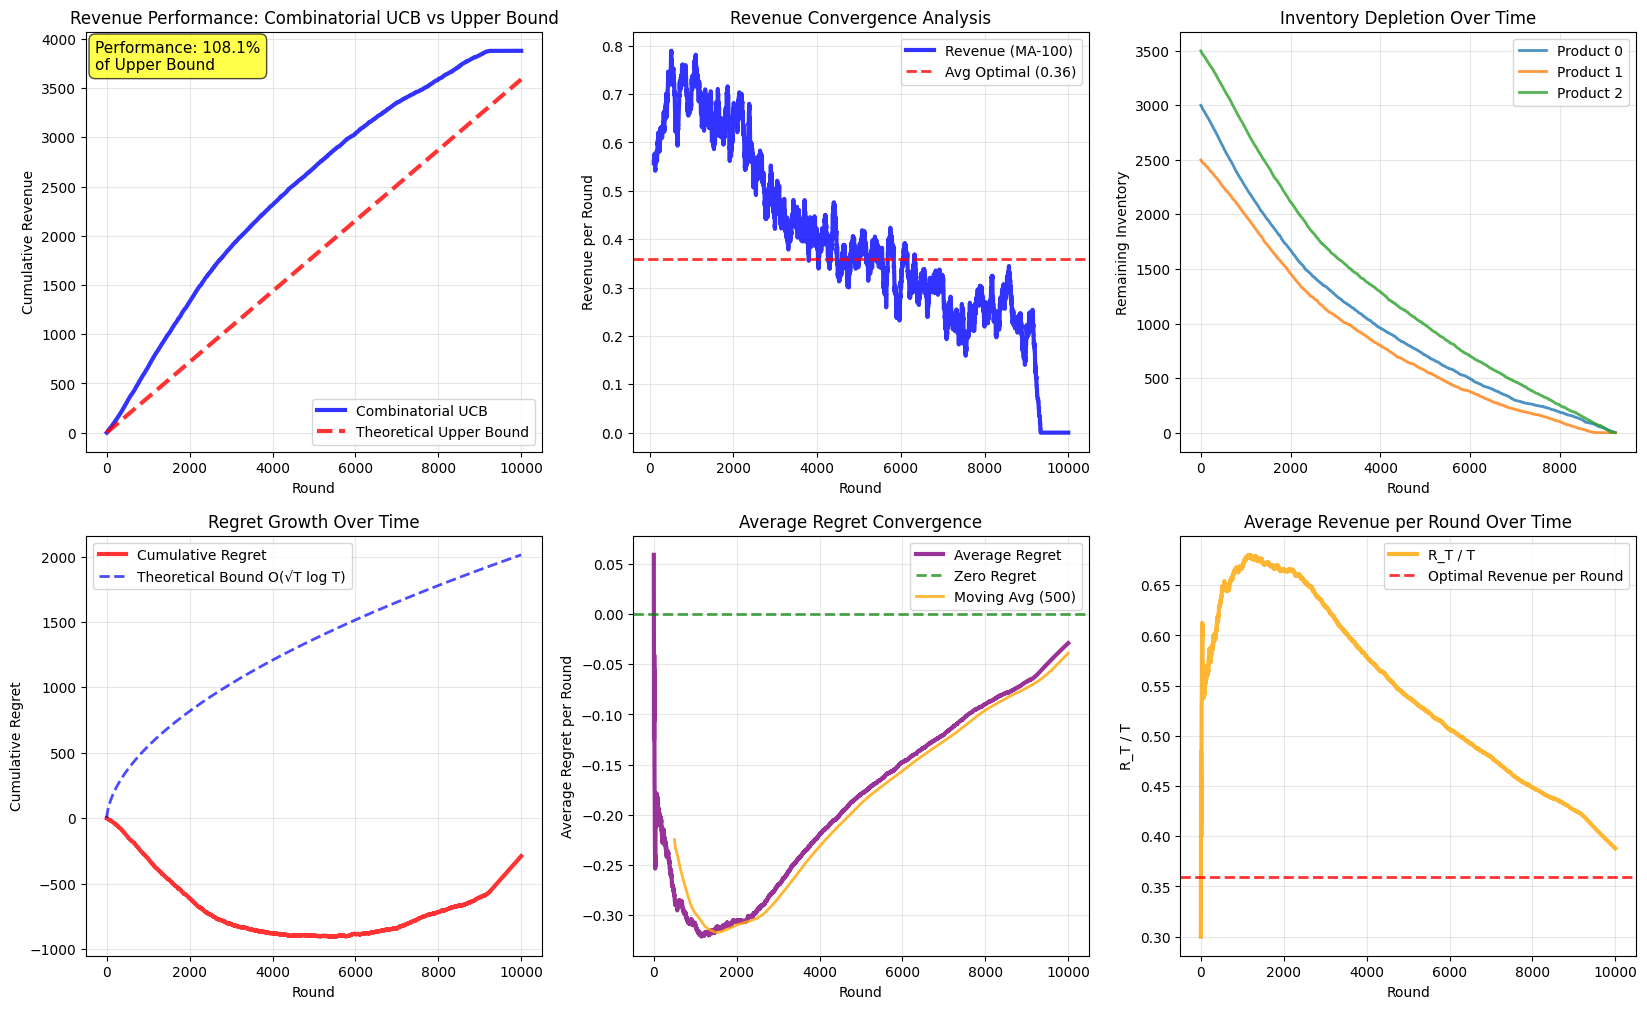

In [13]:
# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy, T, environment)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
optimal_total = optimal_policy['total_expected_revenue_upper_bound']
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# Inventory analysis
print(f"\nInventory utilization by product:")
for i in range(n_products):
    used = inventory_per_product[i] - results['final_inventory'][i]
    utilization = 100 * used / inventory_per_product[i]
    print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")